In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%autosave 20

Autosaving every 20 seconds


In [2]:
from model.model import Net

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import torch
from model.model import Net
from utils.optimizer import get_optimizer,run_lrfinder
from utils.model_fit import training,testing
from utils.data_loader import MNISTDataLoader
from torch import nn
import json
import plotext as plt
import numpy as np
import random
import os
import sys
from rf_calc import receptive_field
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import torchvision
from itertools import islice
import datetime
import argparse

In [5]:
def set_seed(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    # If using torch.backends.cudnn, set the following for reproducibility
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def get_model(device):
    model = Net().to(device)
    # model = model.float()
    return model

In [6]:
def run_model(model,device,batch_size,epochs,optimizer,scheduler,use_scheduler,best_model,version="v1",notes=""):
    # Create unique run name with version and timestamp
    timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
    run_name = f"experiment_{version}_{timestamp}"
    current_lr = optimizer.param_groups[0]['lr']
    train_losses = []
    train_accuracy = []
    test_losses =[]
    test_accuracy = []
    print(summary(model, (1,28, 28 )))
    # _ = receptive_field(model,28)
    
    for EPOCHS in range(0,epochs):
        train_loss, train_acc = training(model,device,train_loader,optimizer,EPOCHS)
        train_losses.append(train_loss)
        train_accuracy.append(train_acc)

        test_loss,test_acc = testing(model,device,test_loader,EPOCHS)
        test_accuracy.append(test_acc)
        test_losses.append(test_loss)    
        if (scheduler_type == 'reducelronplateau') & (use_scheduler ==True):
            scheduler.step(test_loss)
            current_lr = optimizer.param_groups[0]['lr']
        elif (scheduler_type == 'steplr') & (use_scheduler ==True):
            scheduler.step()
            current_lr = scheduler.get_last_lr()[0]
        else:
            current_lr = optimizer.param_groups[0]['lr']

        try:
            if len(test_accuracy) > 1:
                if (EPOCHS >= 3 and 
                    max(test_accuracy[:-1]) < test_accuracy[-1] and 
                    max(test_accuracy) >= best_model):
                    
                    checkpoint = {
                        'epoch': EPOCHS + 1,
                        'valid_loss_min': test_losses[-1],
                        'state_dict': model.state_dict(),
                        'optimizer': optimizer.state_dict(),
                    }
                    
                    file_name = f"./model_folder/modelbest_{test_accuracy[-1]:.4f}_epoch_{EPOCHS}.pt"
                    torch.save(checkpoint, file_name)
                    print(f"Target Achieved: {max(test_accuracy) * 100:.2f}% Test Accuracy!!")
                else:
                    print("Conditions not met for saving the model.")
            else:
                print("Insufficient test accuracy data.")
        except Exception as e:
            print(f"Model saving failed: {e}")

        print(f"LR: {current_lr}\n")
    return model,train_losses, train_accuracy,test_losses,test_accuracy

In [7]:
def load_config():
    with open('config.json', 'r') as f:
        return json.load(f)

In [8]:
def get_loss_function(loss_type):
    if loss_type is None:
        return nn.NLLLoss()   
    loss_types = {
        'cross_entropy': nn.CrossEntropyLoss(),
        'mse': nn.MSELoss(),
        'nll': nn.NLLLoss()
    }
    return loss_types.get(loss_type.lower(), nn.CrossEntropyLoss())

In [9]:
config = load_config()

# Set seed from config
set_seed(config['seed'])

In [10]:
# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
# Get loss function and scheduler settings from config
loss_fn = get_loss_function(config['training'].get('loss_type'))
use_scheduler = config['training'].get('use_scheduler', False)
scheduler_type = config['training'].get('scheduler_type', 'steplr')
runlr_finer = config['training'].get('runlr_finer', False)
use_scheduler = bool(use_scheduler)
runlr_finer = bool(runlr_finer)

In [11]:
best_model = config['best_model']
version = 'v1'
notes = config['training'].get('notes', '')

In [12]:
# Set seed from config
_ = torch.manual_seed(config['seed'])
if torch.cuda.is_available():
    _ = torch.cuda.manual_seed(config['seed'])

In [13]:
# Get batch size based on device
batch_size = config['training']['batch_size']
epochs = config['training']['epochs']

In [14]:
model = get_model(device)
data_loader = MNISTDataLoader(batch_size=batch_size)
train_loader, test_loader = data_loader.get_data_loaders()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:30<00:00, 49.33it/s]


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.05E-01


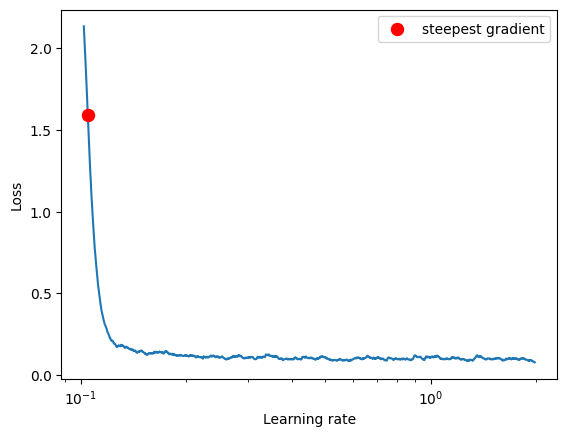

Loss: 0.07525263255573485 LR: 0.10470379786343671
[0.10470379786343671]


In [15]:
if runlr_finer:
    lrs,_ = run_lrfinder(
        model, 
        device, 
        train_loader, 
        test_loader, 
        start_lr=config['training']['start_lr'],
        end_lr=config['training']['end_lr'],
            lr_iter=config['training'].get('lr_iter', 1000)
        )
    print(lrs)
else:
    lrs = [0.015]

In [16]:
optimizer,scheduler = get_optimizer(model,scheduler = use_scheduler,\
                          scheduler_type = scheduler_type,lr = lrs[0])

In [17]:
model,train_losses, train_accuracy,test_losses,test_accuracy= run_model(model,device,batch_size,epochs,optimizer,scheduler,use_scheduler,best_model,version,notes)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             900
       BatchNorm2d-6           [-1, 10, 24, 24]              20
              ReLU-7           [-1, 10, 24, 24]               0
           Dropout-8           [-1, 10, 24, 24]               0
            Conv2d-9           [-1, 15, 22, 22]           1,350
      BatchNorm2d-10           [-1, 15, 22, 22]              30
             ReLU-11           [-1, 15, 22, 22]               0
          Dropout-12           [-1, 15, 22, 22]               0
        MaxPool2d-13           [-1, 15, 11, 11]               0
           Conv2d-14           [-1, 10,

Train ==> Epochs: 0 Batch:  468 loss: 0.08429612964391708 Accuracy: 93.73% : 100%|██████████████████████████| 469/469 [00:09<00:00, 47.54it/s]
Test ==> Epochs: 0 Batch:  78 loss: 0.04751643937379122 Accuracy: 98.44% : 100%|█████████████████████████████| 79/79 [00:00<00:00, 122.76it/s]


Insufficient test accuracy data.
LR: 0.10470379786343671



Train ==> Epochs: 1 Batch:  468 loss: 0.07999590039253235 Accuracy: 97.16% : 100%|██████████████████████████| 469/469 [00:11<00:00, 41.56it/s]
Test ==> Epochs: 1 Batch:  78 loss: 0.04003035141229629 Accuracy: 98.68% : 100%|█████████████████████████████| 79/79 [00:00<00:00, 131.14it/s]


Conditions not met for saving the model.
LR: 0.10470379786343671



Train ==> Epochs: 2 Batch:  468 loss: 0.06669685989618301 Accuracy: 97.56% : 100%|██████████████████████████| 469/469 [00:11<00:00, 41.25it/s]
Test ==> Epochs: 2 Batch:  78 loss: 0.038444595198333265 Accuracy: 98.84% : 100%|████████████████████████████| 79/79 [00:00<00:00, 150.32it/s]


Conditions not met for saving the model.
LR: 0.10470379786343671



Train ==> Epochs: 3 Batch:  468 loss: 0.05630810558795929 Accuracy: 97.83% : 100%|██████████████████████████| 469/469 [00:11<00:00, 41.42it/s]
Test ==> Epochs: 3 Batch:  78 loss: 0.027877245303243398 Accuracy: 99.13% : 100%|████████████████████████████| 79/79 [00:00<00:00, 146.80it/s]


Conditions not met for saving the model.
LR: 0.10470379786343671



Train ==> Epochs: 4 Batch:  468 loss: 0.06767883896827698 Accuracy: 97.93% : 100%|██████████████████████████| 469/469 [00:11<00:00, 41.61it/s]
Test ==> Epochs: 4 Batch:  78 loss: 0.02411178403198719 Accuracy: 99.30% : 100%|█████████████████████████████| 79/79 [00:00<00:00, 137.61it/s]


Target Achieved: 99.30% Test Accuracy!!
LR: 0.10470379786343671



Train ==> Epochs: 5 Batch:  468 loss: 0.03669905662536621 Accuracy: 98.07% : 100%|██████████████████████████| 469/469 [00:11<00:00, 41.56it/s]
Test ==> Epochs: 5 Batch:  78 loss: 0.02256702058017254 Accuracy: 99.34% : 100%|█████████████████████████████| 79/79 [00:00<00:00, 139.34it/s]


Target Achieved: 99.34% Test Accuracy!!
LR: 0.10470379786343671



Train ==> Epochs: 6 Batch:  468 loss: 0.08133464306592941 Accuracy: 98.09% : 100%|██████████████████████████| 469/469 [00:11<00:00, 41.60it/s]
Test ==> Epochs: 6 Batch:  78 loss: 0.02199115399904549 Accuracy: 99.32% : 100%|█████████████████████████████| 79/79 [00:00<00:00, 137.22it/s]


Conditions not met for saving the model.
LR: 0.10470379786343671



Train ==> Epochs: 7 Batch:  468 loss: 0.07088207453489304 Accuracy: 98.23% : 100%|██████████████████████████| 469/469 [00:11<00:00, 41.57it/s]
Test ==> Epochs: 7 Batch:  78 loss: 0.022306216959655286 Accuracy: 99.29% : 100%|████████████████████████████| 79/79 [00:00<00:00, 139.40it/s]


Conditions not met for saving the model.
LR: 0.10470379786343671



Train ==> Epochs: 8 Batch:  468 loss: 0.04231416806578636 Accuracy: 98.25% : 100%|██████████████████████████| 469/469 [00:11<00:00, 41.63it/s]
Test ==> Epochs: 8 Batch:  78 loss: 0.021874626899976282 Accuracy: 99.27% : 100%|████████████████████████████| 79/79 [00:00<00:00, 133.45it/s]


Conditions not met for saving the model.
LR: 0.10470379786343671



Train ==> Epochs: 9 Batch:  468 loss: 0.2045329362154007 Accuracy: 98.25% : 100%|███████████████████████████| 469/469 [00:11<00:00, 41.50it/s]
Test ==> Epochs: 9 Batch:  78 loss: 0.020486892035603523 Accuracy: 99.28% : 100%|████████████████████████████| 79/79 [00:00<00:00, 139.73it/s]


Conditions not met for saving the model.
LR: 0.10470379786343671



Train ==> Epochs: 10 Batch:  468 loss: 0.018625205382704735 Accuracy: 98.31% : 100%|████████████████████████| 469/469 [00:11<00:00, 41.20it/s]
Test ==> Epochs: 10 Batch:  78 loss: 0.02067614062204957 Accuracy: 99.33% : 100%|████████████████████████████| 79/79 [00:00<00:00, 144.35it/s]


Conditions not met for saving the model.
LR: 0.10470379786343671



Train ==> Epochs: 11 Batch:  468 loss: 0.031214773654937744 Accuracy: 98.32% : 100%|████████████████████████| 469/469 [00:11<00:00, 41.60it/s]
Test ==> Epochs: 11 Batch:  78 loss: 0.018454977151192726 Accuracy: 99.48% : 100%|███████████████████████████| 79/79 [00:00<00:00, 138.87it/s]


Target Achieved: 99.48% Test Accuracy!!
LR: 0.10470379786343671



Train ==> Epochs: 12 Batch:  468 loss: 0.02585853822529316 Accuracy: 98.38% : 100%|█████████████████████████| 469/469 [00:11<00:00, 41.73it/s]
Test ==> Epochs: 12 Batch:  78 loss: 0.01925792232071981 Accuracy: 99.42% : 100%|████████████████████████████| 79/79 [00:00<00:00, 140.99it/s]


Conditions not met for saving the model.
LR: 0.10470379786343671



Train ==> Epochs: 13 Batch:  468 loss: 0.08599048107862473 Accuracy: 98.46% : 100%|█████████████████████████| 469/469 [00:11<00:00, 41.71it/s]
Test ==> Epochs: 13 Batch:  78 loss: 0.016969882976193913 Accuracy: 99.51% : 100%|███████████████████████████| 79/79 [00:00<00:00, 128.36it/s]


Target Achieved: 99.51% Test Accuracy!!
LR: 0.10470379786343671



Train ==> Epochs: 14 Batch:  468 loss: 0.02468302845954895 Accuracy: 98.46% : 100%|█████████████████████████| 469/469 [00:11<00:00, 42.26it/s]
Test ==> Epochs: 14 Batch:  78 loss: 0.01991891371756792 Accuracy: 99.41% : 100%|████████████████████████████| 79/79 [00:00<00:00, 150.64it/s]

Conditions not met for saving the model.
LR: 0.10470379786343671



In [18]:
print("Max Train Accuracy: ",max(train_accuracy))
print("Max Test Accuracy: ",max(test_accuracy))

Max Train Accuracy:  0.9846333333333334
Max Test Accuracy:  0.9951


Text(0.5, 1.0, 'Model Accuracy')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Accuracy')

Text(0.5, 1.0, 'Model Loss')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

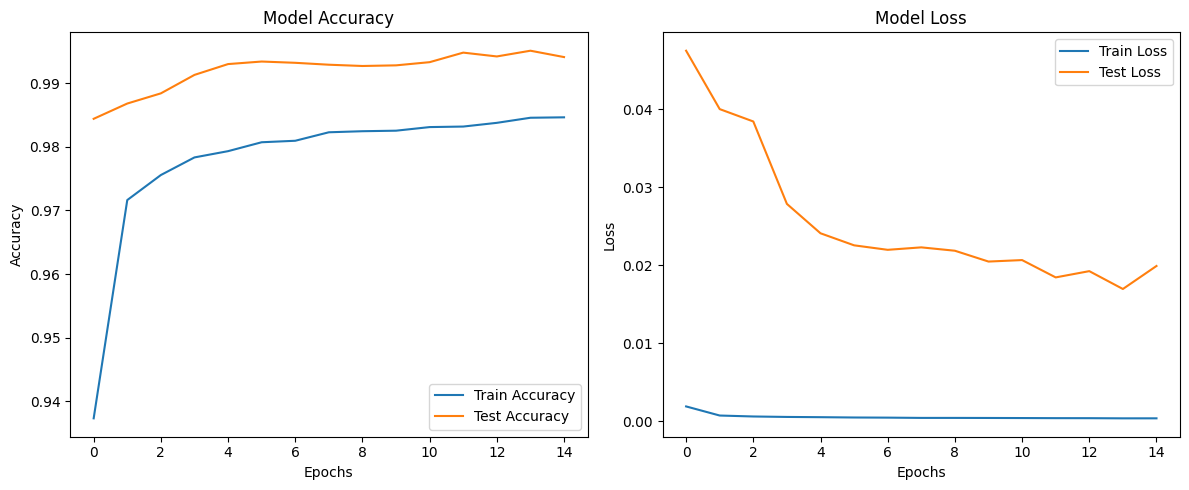

In [19]:
import matplotlib.pyplot as plt
# Create a figure with 1 row and 2 columns of subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Adjust figsize as needed

# Plot accuracy on the first subplot
axes[0].plot(train_accuracy, label="Train Accuracy")
axes[0].plot(test_accuracy, label="Test Accuracy")
axes[0].set_title("Model Accuracy")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Accuracy")
axes[0].legend()

# Plot loss on the second subplot
axes[1].plot(train_losses, label="Train Loss")
axes[1].plot(test_losses, label="Test Loss")
axes[1].set_title("Model Loss")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss")
axes[1].legend()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

### Infrencing 

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import logging
from tqdm import tqdm
import torch
from torchvision import transforms
from PIL import Image
from model.model import Net
import json
import os
import sys
from utils.data_loader import MNISTDataLoader
from torchvision import datasets, transforms
from torch.utils.data import Dataset, ConcatDataset
import matplotlib.pyplot as plt

In [ ]:
# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Set up the path for the model and configuration
# sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))

def load_best_model(path="", device="cuda"):
    scores = []
    for index, file in enumerate(os.listdir(path)):
        if file.endswith(".pt"):
            scores.append(float(file.split("_")[1]))

    best_score = max(scores)
    max_acc = scores.index(best_score)
    name = os.listdir(path)[max_acc]
    model = Net().to(device)

    # Log the model being loaded
    logging.info(f"Loading model: {name}")

    # Load the state_dict from the saved model with weights_only=True
    checkpoint = torch.load(f'./model_folder/{name}', map_location=device, weights_only=True)

    # Load only the matching parameters
    model_dict = model.state_dict()
    pretrained_dict = checkpoint['state_dict'] if 'state_dict' in checkpoint else checkpoint

    # Filter out unnecessary keys
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict and model_dict[k].size() == v.size()}

    # Overwrite entries in the existing state dict
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)

    model.eval()
    return model

def infer(model, device, image_path, mean, std):
    transform = transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
        transforms.Normalize((mean,), (std,))
    ])
    
    # Load and preprocess the image
    image = Image.open(image_path).convert('L')  # Convert to grayscale
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device

    with torch.no_grad():
        output = model(image)
        prediction = output.argmax(dim=1, keepdim=True)  # Get the predicted class

    return prediction.item()  # Return the predicted class as an integer

def load_config():
    with open('config.json', 'r') as f:
        return json.load(f)

def get_data_loaders(mean, std):
    train_transforms = transforms.Compose([
        transforms.Resize((28, 28)),
        # transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.RandomPerspective(distortion_scale=0.2, p=0.5, interpolation=transforms.InterpolationMode.NEAREST),
        transforms.RandomRotation(degrees=15, expand=False, center=None, fill=(mean) ),
        transforms.ToTensor(),
        transforms.Normalize((mean,), (std,))
    ])

    test_transforms = transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
        transforms.Normalize((mean,), (std,))
    ])
    
    train_data = datasets.MNIST(
        root='.data',
        train=True,
        download=True,
        transform=train_transforms  # Use train_transforms
    )

    test_data = datasets.MNIST(
        root='.data',
        train=False,
        download=True,
        transform=test_transforms  # Use test_transforms
    )
    
    return train_data, test_data

def validate_model(model, device, data_loader, source):
    model.eval()
    incorrect_predictions = []
    
    with torch.no_grad():
        for images, labels in tqdm(data_loader, desc=f"Validating {source}", unit="batch"):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            incorrect_indices = (predicted != labels).nonzero(as_tuple=True)[0]
            
            for index in incorrect_indices:
                # Get the confidence score (maximum probability)
                confidence = torch.softmax(outputs[index], dim=0).max().item()
                incorrect_predictions.append({
                    'image': images[index].cpu(),
                    'predicted': predicted[index].cpu().item(),
                    'actual': labels[index].cpu().item(),
                    'confidence': confidence,  # Store the confidence score
                    'source': source
                })
    
    # Sort by confidence score in ascending order
    incorrect_predictions.sort(key=lambda x: x['confidence'])
    return incorrect_predictions

def plot_incorrect_predictions(incorrect_data, max_images=20, source=""):
    num_incorrect = len(incorrect_data)
    num_to_plot = min(num_incorrect, max_images)
    cols = 5
    rows = (num_to_plot // cols) + (num_to_plot % cols > 0)

    plt.figure(figsize=(15, rows * 2))
    for i, item in enumerate(incorrect_data[:num_to_plot]):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(item['image'].squeeze(), cmap='gray')
        plt.title(f'Actual: {item["actual"]}\nPred: {item["predicted"]}\nConf: {item["confidence"]:.3f}', 
                 fontsize=8)
        plt.axis('off')

    plt.suptitle(f"Top {num_to_plot} Lowest Confidence Incorrect Predictions\nfrom {source} Dataset", 
                fontsize=12)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    logging.info("Loading configuration...")
    config = load_config()
    
    # Set device
    device = "cuda" if torch.cuda.is_available() else "cpu"
    logging.info(f"Using device: {device}")
    
    # Load model
    model_path = './model_folder/'  # Specify the correct path to your model folder
    model = load_best_model(model_path, device)  # Pass the model path and device
    logging.info("Model loaded successfully.")
    
    # Create an instance of MNISTDataLoader to get mean and std
    data_loader_instance = MNISTDataLoader()
    mean_val, std_val = data_loader_instance._calculate_stats()  # Get mean and std values

    # Get train and test datasets
    train_data, test_data = get_data_loaders(mean_val, std_val)

    # Create DataLoaders for train and test datasets with batch size 128
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=False)

    # Validate the model and get incorrect predictions for train and test datasets
    logging.info("Starting validation on train dataset...")
    incorrect_train_data = validate_model(model, device, train_loader, "train")
    logging.info(f'Number of incorrect predictions in train dataset: {len(incorrect_train_data)}')

    logging.info("Starting validation on test dataset...")
    incorrect_test_data = validate_model(model, device, test_loader, "test")
    logging.info(f'Number of incorrect predictions in test dataset: {len(incorrect_test_data)}')

    # Plot incorrect predictions
    plot_incorrect_predictions(incorrect_train_data, max_images=40, source="Train")
   

In [ ]:
 plot_incorrect_predictions(incorrect_test_data, max_images=40, source="Test")